# Question
What effect, if any, does plate material and thickness have on the performance of a counter flow heat exchanger?
# Hardware
Airflows are
* `Room -> F001(FAN2) -> HEATER2 -> T0 -> T3 -> Room`
* `Room -> F002(FAN1) -> T2 -> T1 -> Room`

Plates are not individually identified other than their construction material

Power supply held at 13V

# Plan
## Test script
`test_hot_fan_step(step_size=25, heater_pwm=15, start_fan_pwm=125)` which is:
1. Full fans, no heat, wait 10 minutes, equilibrate, record a 10s interval of data for later calibration
1. Leave FAN2 on full speed.  For each FAN1 speed up and down:
   1. Wait 10 minutes, equilibrate, and record a 10s interval of data
1. Leave FAN1 on full speed.  For each FAN2 speed up and down:
   1. Wait 10 minutes, equilibrate, and record a 10s interval of data
1. Full fans, no heat, wait 10 minutes, equilibrate, record a 10s interval of data for later calibration

`test_fan_step_pwm_pressure(step_size=2)` which is:
1. Fans off, no heat, wait 20s, equilibrate, record a 10s interval of data for later calibration
2. For each FAN1 and FAN2 speed (symmetric)
3. Set both fan speed, wait 20s, record 10s data interval
4. Fans off, no heat, wait 20s, equilibrate, record a 10s interval of data for later calibration

`test_hot_step` which is:
1. Full fans, no heat, wait 10 minutes, equilibrate, record a 10s interval of data for later calibration
2. For each heater power level
3. set heater power level, wait 10 minutes, equilibrate, record a 10s interval of data
1. Full fans, no heat, wait 10 minutes, equilibrate, record a 10s interval of data for later calibration

## Materials
Test each material according to above script:
1. Switch to two aluminum plates, run `test_hot_fan_step` and `test_fan_step_pwm_pressure` tests
1. Switch to two PETG plates, run `test_hot_fan_step` and `test_fan_step_pwm_pressure` tests
1. Switch to two ABS plates, run `test_hot_fan_step` and `test_fan_step_pwm_pressure` tests
1. Switch to two PLA plates, run `test_hot_fan_step` and `test_fan_step_pwm_pressure` tests

# Test Tracking
Completed
| MATERIAL | PLATES | test_hot_fan_step | test_fan_step_pwm_pressure | test_hot_step |
|----------|--------|-------------------|----------------------------|---------------|
| AL       | 2      |                   |              X             |               |
| PETG     | 2      |                   |                            |               |
| ABS      | 2      |                   |                            |               |
| PLA      | 2      |                   |                            |               |

Data Files
| DATE       | MATERIAL | PLATES | TEST                  | FILENAME                                    |
| ----       | -------- | ------ | --------------------- | ------------------------------------------- |
| 2024-09-29 | AL       | 2      | fan_step_pwm_pressure | 2024-09-29-test_fan_step_pwm_pressure-1.csv |
| 2024-09-30 | AL       | 2      | hot_step              | 2024-09-30-test_hot_step-1.csv              |
| 2024-09-30 | AL       | 2      | hot_fan_step          | 2024-09-30-test_hot_fan_step-1.csv          |


# Calibration
Delta calculation will naturally remove any ambient change
s
Use first data reading (with fans off) to get an offset for 0 delta pressure and apply to all future readings

In [30]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt

def read_heat_exchanger_fanspeed_pressure_csv(csv_file_name):
    data = pd.read_csv(csv_file_name)
    data["DP0"] = data["SENS0_PRESS"] - data["SENS3_PRESS"]
    data["DP1"] = data["SENS2_PRESS"] - data["SENS1_PRESS"]
    dp0_offset = 0 - data["DP0"][0]
    dp1_offset = 0 - data["DP1"][0]
    data["DP0_CALIB"] = data["DP0"] + dp0_offset
    data["DP1_CALIB"] = data["DP1"] + dp1_offset
    return data

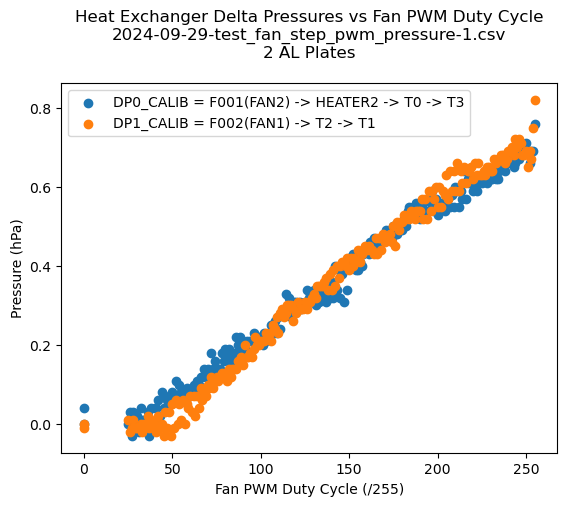

In [6]:
# Just for testing.  Delete me
data = read_heat_exchanger_fanspeed_pressure_csv("data/2024-09-29-test_fan_step_pwm_pressure-1.csv")
plt.title('''Heat Exchanger Delta Pressures vs Fan PWM Duty Cycle
2024-09-29-test_fan_step_pwm_pressure-1.csv
2 AL Plates
''')
plt.ylabel('Pressure (hPa)')
plt.xlabel('Fan PWM Duty Cycle (/255)')
plt.scatter(y=data["DP0_CALIB"], x=data["FAN0"], label="DP0_CALIB = F001(FAN2) -> HEATER2 -> T0 -> T3")
plt.scatter(y=data["DP1_CALIB"], x=data["FAN0"], label="DP1_CALIB = F002(FAN1) -> T2 -> T1")
plt.legend()
plt.show()

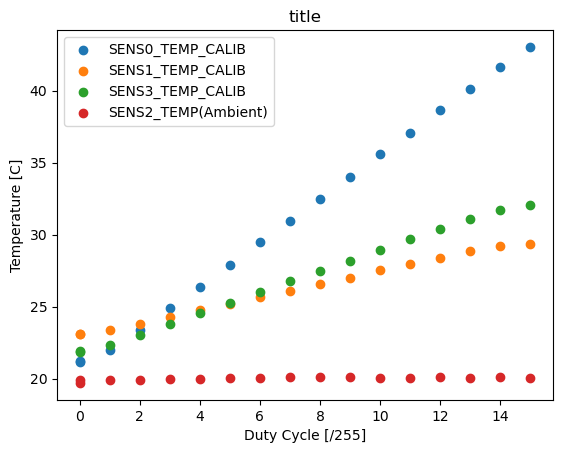

In [10]:


data = pd.read_csv("data/2024-09-30-test_hot_step-1.csv")

starting_ambient_temp = data["SENS2_TEMP"][0]
data["SENS0_TEMP_CALIB"] = data["SENS0_TEMP"] - (data["SENS2_TEMP"] - starting_ambient_temp)
data["SENS1_TEMP_CALIB"] = data["SENS1_TEMP"] - (data["SENS2_TEMP"] - starting_ambient_temp)
data["SENS3_TEMP_CALIB"] = data["SENS3_TEMP"] - (data["SENS2_TEMP"] - starting_ambient_temp)

# remove calibration rows
#data = data.drop(12)
#data = data.drop(0)

plt.title("title")
plt.ylabel('Temperature [C]')
plt.xlabel('Duty Cycle [/255]')
plt.scatter(y=data["SENS0_TEMP_CALIB"], x=data["HEATER1"], label="SENS0_TEMP_CALIB")
plt.scatter(y=data["SENS1_TEMP_CALIB"], x=data["HEATER1"], label="SENS1_TEMP_CALIB")
plt.scatter(y=data["SENS3_TEMP_CALIB"], x=data["HEATER1"], label="SENS3_TEMP_CALIB")
plt.scatter(y=data["SENS2_TEMP"], x=data["HEATER1"], label="SENS2_TEMP(Ambient)")
plt.legend()
plt.show()

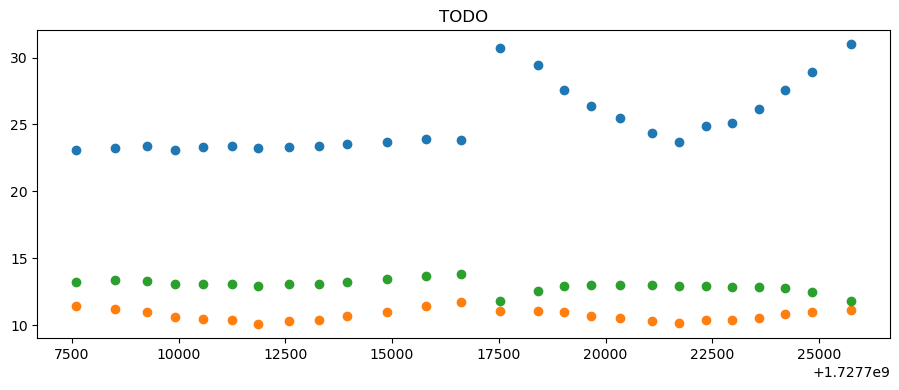

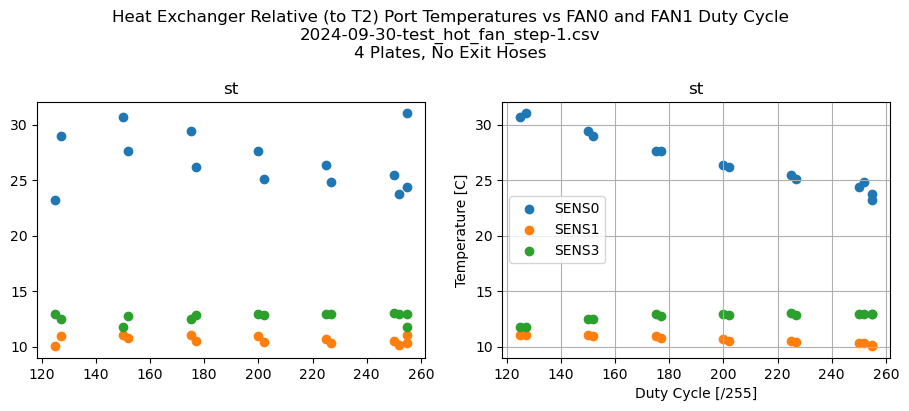

In [108]:
data = pd.read_csv("data/2024-09-30-test_hot_fan_step-1.csv")

data["SENS0_TEMP_OVER_AMBIENT"] = data["SENS0_TEMP"] - data["SENS2_TEMP"]
data["SENS1_TEMP_OVER_AMBIENT"] = data["SENS1_TEMP"] - data["SENS2_TEMP"] 
data["SENS3_TEMP_OVER_AMBIENT"] = data["SENS3_TEMP"] - data["SENS2_TEMP"]

# remove calibration rows
data = data.drop(len(data.index)-1)
data = data.drop(0)

data_fan0_255 = data[data.FAN0==255]
data_fan1_255 = data[data.FAN1==255]

fig = plt.figure(figsize=(11,4))
ax = fig.add_subplot()
ax.set_title("TODO")
ax.scatter(x=data["HOST_INTERVAL_START"], y=data["SENS0_TEMP_OVER_AMBIENT"], label="")
ax.scatter(x=data["HOST_INTERVAL_START"], y=data["SENS1_TEMP_OVER_AMBIENT"], label="")
ax.scatter(x=data["HOST_INTERVAL_START"], y=data["SENS3_TEMP_OVER_AMBIENT"], label="")
plt.show()

fig = plt.figure(figsize=(11,4))
fig.suptitle('''Heat Exchanger Relative (to T2) Port Temperatures vs FAN0 and FAN1 Duty Cycle
2024-09-30-test_hot_fan_step-1.csv
4 Plates, No Exit Hoses''')
fig.subplots_adjust(top=0.75)

ax_fan0 = fig.add_subplot(1,2,1)
ax_fan0.set_title("st")
ax_fan0.scatter(y=data_fan0_255["SENS0_TEMP_OVER_AMBIENT"], x=data_fan1_255["FAN0"], label="SENS0")
ax_fan0.scatter(y=data_fan0_255["SENS1_TEMP_OVER_AMBIENT"], x=data_fan1_255["FAN0"], label="SENS1")
ax_fan0.scatter(y=data_fan0_255["SENS3_TEMP_OVER_AMBIENT"], x=data_fan1_255["FAN0"], label="SENS3")

ax_fan1 = fig.add_subplot(1,2,2)
ax_fan1.set_title("st")
ax_fan1.scatter(y=data_fan0_255["SENS0_TEMP_OVER_AMBIENT"], x=data_fan0_255["FAN1"], label="SENS0")
ax_fan1.scatter(y=data_fan0_255["SENS1_TEMP_OVER_AMBIENT"], x=data_fan0_255["FAN1"], label="SENS1")
ax_fan1.scatter(y=data_fan0_255["SENS3_TEMP_OVER_AMBIENT"], x=data_fan0_255["FAN1"], label="SENS3")


plt.ylabel('Temperature [C]')
plt.xlabel('Duty Cycle [/255]')


plt.grid(True)
plt.legend()
plt.show()